In [1]:
XLA_PYTHON_CLIENT_MEM_FRACTION=.1

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random, jit, grad
import optax
import jax.lax as lax
import pandas as pd

import wandb

import matplotlib
#matplotlib.rcParams.update({'font.size': 12})

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : 8,
    'text.usetex': True,
    'pgf.rcfonts': False,
})



# Initialize the wandb API
api = wandb.Api()

# Replace with your actual entity (username or team) and project name
entity = "neuralmachine"  # e.g., "john_doe" or "my_team"

project = f"correct_MUP_1hidden_both_faster_sub_SUB_FOCUS"

# Retrieve all runs in the project
runs = api.runs(f"{entity}/{project}")



In [ ]:

# Initialize an empty list to collect data from all runs
all_runs_data = []

# Iterate through each run and retrieve its full history
for run in runs:
    print(f"Processing run: {run.id} | Name: {run.name}")

    # Retrieve run configuration
    config = run.config
    
    kmax=config.get("moments", "unknown")
    width = config.get("width", "unknown")  # Default to "unknown" if not found
    
    # Use scan_history to get the full history without downsampling
    run_history = run.scan_history()
    
    # Convert generator to list of dicts
    run_history = list(run_history)
    
    # Convert to pandas DataFrame
    run_df = pd.DataFrame(run_history)
    
    # Add run-specific information
    run_df['run_id'] = run.id
    run_df['run_name'] = run.name
    run_df['width'] = width
    
    # Append to the list
    all_runs_data.append(run_df)
    

Processing run: awt32prk | Name: golden-bush-30
Processing run: q7yuzjjd | Name: swept-smoke-31
Processing run: tmjlr2sz | Name: magic-cosmos-32
Processing run: 5nb8lvcb | Name: magic-wildflower-33
Processing run: nrj9aghf | Name: neat-sunset-34
Processing run: mporcuxo | Name: resilient-star-35
Processing run: bo95laig | Name: good-plant-36
Processing run: im327ibr | Name: efficient-energy-37
Processing run: m1c1xsum | Name: gallant-thunder-38
Processing run: ue0yfbd7 | Name: effortless-wind-39
Processing run: 6a7034sx | Name: colorful-pine-40
Processing run: 24rppx1c | Name: deft-dew-41
Processing run: l00129i2 | Name: electric-frost-42
Processing run: sxu9uot6 | Name: charmed-morning-43
Processing run: d87zjkga | Name: young-valley-44
Processing run: tioofs8s | Name: sparkling-microwave-45
Processing run: gu55ff8v | Name: lilac-haze-46
Processing run: vjohgqg5 | Name: absurd-snow-48
Processing run: 45vmgugg | Name: light-dust-49
Processing run: fdobpq5j | Name: ruby-forest-50
Proces

Processing run: ghi7nchw | Name: generous-deluge-226
Processing run: hw369mga | Name: tough-bee-227
Processing run: p4f0dg87 | Name: fiery-capybara-228
Processing run: 72l8lf4g | Name: apricot-oath-229
Processing run: 2q5jsore | Name: skilled-universe-230
Processing run: kgca9bkb | Name: light-bird-231
Processing run: vourwonq | Name: exalted-pine-232
Processing run: sta3f67i | Name: lucky-brook-233
Processing run: 40wfqf8e | Name: gentle-disco-234
Processing run: ftttw4st | Name: dulcet-sun-235
Processing run: eo0varzb | Name: distinctive-cherry-236
Processing run: ltxzx8pb | Name: denim-flower-237
Processing run: vwyejsfu | Name: giddy-tree-238
Processing run: epj2pzb0 | Name: ethereal-glitter-239
Processing run: d8u4ydys | Name: laced-cherry-240
Processing run: jvux2wac | Name: glamorous-night-241
Processing run: wvwn9gn2 | Name: glorious-grass-242
Processing run: rw81r7b5 | Name: soft-wood-243
Processing run: lvetxyd9 | Name: olive-dust-244
Processing run: hxv585ae | Name: misunder

In [4]:

# Concatenate all run data into a single DataFrame
df = pd.concat(all_runs_data, ignore_index=True)

# Optional: Save the DataFrame to a CSV file for future use
df.to_csv('wandb_exported_full_data_supp.csv', index=False)
print("Data exported to 'wandb_exported_full_data_supp.csv'.")

# Display basic information about the DataFrame
print("DataFrame Information:")
print(df.info())

# Display a preview of the DataFrame
print("\nDataFrame Preview:")
print(df.head())



Data exported to 'wandb_exported_full_data_supp.csv'.
DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225120 entries, 0 to 225119
Data columns (total 49 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   sub_moments-1/ED_sub_est        16080 non-null   float64
 1   norm_moments-1/3-est            16080 non-null   float64
 2   sub_moments-1/3-sub_est         16080 non-null   float64
 3   _runtime                        225120 non-null  float64
 4   iter                            32160 non-null   float64
 5   norm_moments-1/4-est            16080 non-null   float64
 6   norm_sub_moments-1/5-sub_naive  16080 non-null   float64
 7   moments-1/4-est                 16080 non-null   float64
 8   norm_moments-1/4-naive          16080 non-null   float64
 9   moments-1/5-naive               16080 non-null   float64
 10  sub_moments-1/1-sub_naive       16080 non-null   float64
 11  m

In [2]:
csv_file_path='wandb_exported_full_data_supp.csv'
df = pd.read_csv(csv_file_path)


In [3]:
kmax=5

trloss=[]
teloss=[]

#plt.figure(figsize=(12, 6))
widths=[]
# Iterate through each unique run and plot its training and test loss
m_n=[]
e_n=[]
m_s_n=[]
m_e=[]
e_e=[]
m_s_e=[]
e_s_e=[]
m_r_n=[]
m_r_s_n=[]
m_r_e=[]
m_r_s_e=[]
for run_id in df['run_id'].unique():
    run_data = df[df['run_id'] == run_id]
    
    nanfree=~np.isnan(run_data['iter'])
    it=np.array(run_data['iter'][nanfree])
    
    trloss.append(run_data['loss/train'][nanfree])
    teloss.append(run_data['loss/test'][nanfree])
    widths.append(np.array(run_data['width'])[0])
    

    
    itm=run_data['mom_iter']
    itm=np.array(itm)
    itm=itm[~np.isnan(itm)]

    
    layn=0
    
    mom_naive=[]
    ed_naive=[]
    momsub_naive=[]
    mom_est=[]
    ed_est=[]
    momsub_est=[]
    edsub_est=[]
    mom_norm_naive=[]
    momsub_norm_naive=[]
    mom_norm_est=[]
    momsub_norm_est=[]
    for i in range(kmax):
        'norm_moments-1/2-est'
        'norm_sub_moments-1/2-sub_est'
        'norm_sub_moments-1/2-sub_naive'
    
        d=run_data[f"moments-{layn + 1}/{i + 1}-naive"]
        mom_naive.append(d[~np.isnan(d)])
        d=run_data[f"sub_moments-{layn + 1}/{i + 1}-sub_naive"]
        momsub_naive.append(d[~np.isnan(d)]) 
        d=run_data[f"norm_moments-{layn + 1}/{i + 1}-naive"]
        mom_norm_naive.append(d[~np.isnan(d)])
        
        d=run_data[f"norm_sub_moments-{layn + 1}/{i + 1}-sub_naive"] 
        momsub_norm_naive.append(d[~np.isnan(d)]) ###
        
        if i<kmax-1:
            d=run_data[f"moments-{layn + 1}/{i + 2}-est"]
            mom_est.append(d[~np.isnan(d)])
            d=run_data[f"sub_moments-{layn + 1}/{i + 2}-sub_est"]
            momsub_est.append(d[~np.isnan(d)])
            
            d=run_data[f"norm_moments-{layn + 1}/{i + 2}-est"] 
            mom_norm_est.append(d[~np.isnan(d)]) ###
            d=run_data[f"norm_sub_moments-{layn + 1}/{i + 2}-sub_est"]
            momsub_norm_est.append(d[~np.isnan(d)]) ###

        #ed_naive.append(run_data[f"moments-{layn + 1}/ED"][~np.isnan(itm)])
        #ed_est.append(run_data[f"moments-{layn + 1}/ED_est"][~np.isnan(itm)])
        #edsub_est.append(run_data[f"sub_moments-{layn + 1}/ED_sub_est"][~np.isnan(itm)])
        
    m_n.append(mom_naive)
    e_n.append(ed_naive)
    m_s_n.append(momsub_naive)
    m_e.append(mom_est)
    m_s_e.append(momsub_est)
    e_s_e.append(edsub_est)
    m_r_n.append(mom_norm_naive)
    m_r_s_n.append(momsub_norm_naive) ###
    m_r_e.append(mom_norm_est) ###
    m_r_s_e.append(momsub_norm_est) ###


trloss=np.array(trloss).T
teloss=np.array(teloss).T
widths=np.array(widths)

m_n=np.array(m_n)
m_e=np.array(m_e)
m_s_n=np.array(m_s_n)
m_s_e=np.array(m_s_e)
m_r_n=np.array(m_r_n)

m_r_e=np.array(m_r_e) ###
m_r_s_n=np.array(m_r_s_n) ###
m_r_s_e=np.array(m_r_s_e) ###

#e_n=np.array(e_n)
#e_e=np.array(e_e)
#e_s_e=np.array(e_s_e)

itm=itm[~np.isnan(itm)]

#plt.xlabel('Iteration')
#plt.ylabel('Loss')
#plt.title('Training and Test Loss over Iterations')
#plt.legend()
#plt.grid(True)
#plt.show()


In [9]:
def plot_ci(ax,xoi,qoi,c='k',zorder=10,alphaf=0.1,alphap=1,label='',ls='-'):
    yval=np.nanmedian(qoi,axis=1)
    lower=np.nanquantile(qoi,axis=1,q=0.25)
    upper=np.nanquantile(qoi,axis=1,q=0.75)
    asymmetric_error = [yval-lower, upper-yval]

    yval=np.nanmean(qoi,axis=1)
    ax.fill_between(xoi, lower, upper, color=c, alpha=alphaf,edgecolor='none',zorder=zorder)#, **fill_kwargs)
    ax.plot(xoi, yval, color=c,lw=1,alpha=alphap,label=label,ls=ls,zorder=zorder)

widthu=np.unique(widths)

color = plt.cm.rainbow(np.linspace(0, 1, len(widthu)))


fig,ax=plt.subplots(kmax-1,4,figsize=(10,6))
#fig,ax=plt.subplots(kmax-1,2,figsize=(5,6))
for mid in range(kmax-1):
    data0=m_n[:,mid+1,:]
    data1=m_e[:,mid,:]
    meand=[]
    meand=[]
    for i,width in enumerate(widthu):
        meand.append(np.mean(data0[widths==width,:],axis=0))
        meand.append(np.mean(data1[widths==width,:],axis=0))
        
        plot_ci(ax[mid][0],itm,data0[widths==width,:].T,c=color[i],alphap=0.7,alphaf=0.1,label=width)
        plot_ci(ax[mid][1],itm,data1[widths==width,:].T,c=color[i],alphap=0.7,alphaf=0.1,label=width)
        
    ymax = np.max(np.array(meand))
    ymin = np.min(np.array(meand))
        
    ax[mid][0].set_ylim([0,ymax])
    ax[mid][1].set_ylim([0,ymax])
    #ax[mid][2].set_ylim([ymin,ymax])
    #ax[mid][3].set_ylim([ymin,ymax])
    

    #ax[mid][0].set_yscale('log')
    #ax[mid][1].set_yscale('log')
    #ax[mid][2].set_yscale('log')
    #ax[mid][3].set_yscale('log')
        
#fig.tight_layout()
        
    
#fig,ax=plt.subplots(kmax-1,2,figsize=(5,6))
for mid in range(kmax-1):
    data0=m_r_n[:,mid+1,:]
    data1=m_r_e[:,mid,:]
    meand=[]
    meand=[]
    for i,width in enumerate(widthu):
        meand.append(np.mean(data0[widths==width,:],axis=0))
        meand.append(np.mean(data1[widths==width,:],axis=0))
        
        plot_ci(ax[mid][2],itm,data0[widths==width,:].T,c=color[i],alphap=0.7,alphaf=0.1,label=width)
        plot_ci(ax[mid][3],itm,data1[widths==width,:].T,c=color[i],alphap=0.7,alphaf=0.1,label=width)
        
    ymax = np.max(np.array(meand))
    ymin = np.min(np.array(meand))
        
    ax[mid][2].set_ylim([0,ymax])
    ax[mid][3].set_ylim([0,ymax])
    #ax[mid][2].set_ylim([ymin,ymax])
    #ax[mid][3].set_ylim([ymin,ymax])
    

    #ax[mid][0].set_yscale('log')
    #ax[mid][1].set_yscale('log')
    #ax[mid][2].set_yscale('log')
    #ax[mid][3].set_yscale('log')
    
ax[0][0].set_ylabel(r'$\hat{m}(2)$')
ax[1][0].set_ylabel(r'$\hat{m}(3)$')
ax[2][0].set_ylabel(r'$\hat{m}(4)$')
ax[3][0].set_ylabel(r'$\hat{m}(5)$')

ax[-1][0].set_xlabel('Epoch')
ax[-1][1].set_xlabel('Epoch')
ax[-1][2].set_xlabel('Epoch')
ax[-1][3].set_xlabel('Epoch')

ax[0][0].set_title('Naive')
ax[0][1].set_title('Ours')

ax[0][2].set_title(r'Naive (norm. $\Phi$)')
ax[0][3].set_title(r'Ours (norm. $\Phi$)')

#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = dict(zip(labels, handles))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),title="Width")
fig.tight_layout()



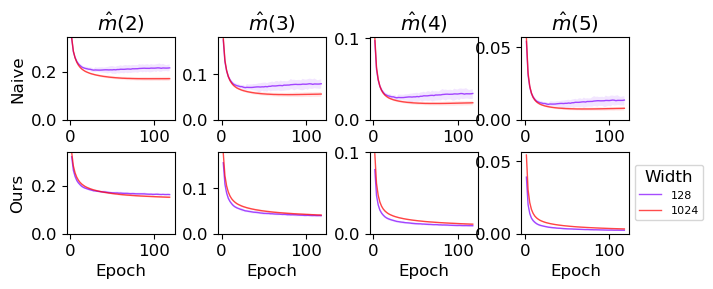

In [9]:

widthu=np.unique(widths)

color = plt.cm.rainbow(np.linspace(0, 1, len(widthu)))


fig,ax=plt.subplots(2,4,figsize=(10,4))

start=1
#fig,ax=plt.subplots(kmax-1,2,figsize=(5,6))
for mid in range(kmax-1):
    data0=m_r_n[:,mid+1,start:]
    data1=m_r_e[:,mid,start:]
    meand=[]
    meand=[]
    for i,width in enumerate(widthu):
        meand.append(np.mean(data0[widths==width,:],axis=0))
        meand.append(np.mean(data1[widths==width,:],axis=0))
        
        plot_ci(ax[0][mid],itm[start:],data0[widths==width,:].T,c=color[i],alphap=0.7,alphaf=0.1,label=width)
        plot_ci(ax[1][mid],itm[start:],data1[widths==width,:].T,c=color[i],alphap=0.7,alphaf=0.1,label=width)
        
    ymax = np.max(np.array(meand))
    ymin = np.min(np.array(meand))
        
    ax[0][mid].set_ylim([0,ymax])
    ax[1][mid].set_ylim([0,ymax])
    #ax[mid][2].set_ylim([ymin,ymax])
    #ax[mid][3].set_ylim([ymin,ymax])
    

    #ax[mid][0].set_yscale('log')
    #ax[mid][1].set_yscale('log')
    #ax[mid][2].set_yscale('log')
    #ax[mid][3].set_yscale('log')
    
ax[0][0].set_title(r'$\hat{m}(2)$')
ax[0][1].set_title(r'$\hat{m}(3)$')
ax[0][2].set_title(r'$\hat{m}(4)$')
ax[0][3].set_title(r'$\hat{m}(5)$')

ax[-1][0].set_xlabel('Epoch')
ax[-1][1].set_xlabel('Epoch')
ax[-1][2].set_xlabel('Epoch')
ax[-1][3].set_xlabel('Epoch')

ax[0][0].set_ylabel('Naive')#,rotation=0)
ax[1][0].set_ylabel('Ours')

#ax[0][2].set_title(r'Naive (normalized $\Phi$)')
#ax[0][3].set_title(r'Ours (normalized $\Phi$)')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),title="Width",fontsize=8)
fig.tight_layout()


fig.set_size_inches(w=6.75133, h=2.7)
#plt.savefig('train_curves_supp.pdf', bbox_inches='tight')
#plt.savefig('train_curves_supp.pgf' , bbox_inches='tight')


In [16]:


# m_r_e
# m_r_s_n
# m_r_s_e

widthu=np.unique(widths)

color = plt.cm.rainbow(np.linspace(0, 1, len(widthu)))


fig,ax=plt.subplots(1,4,figsize=(10,4))

start=1
#fig,ax=plt.subplots(kmax-1,2,figsize=(5,6))
for mid in range(kmax-1):
    data0=m_r_n[:,mid+1,start:]
    data1=m_r_e[:,mid,start:]
    
    data2=m_r_s_n[:,mid+1,start:]
    data3=m_r_s_e[:,mid,start:]
    
    meand=[]
    for i,width in enumerate(widthu):
        if width==1024:
            meand.append(np.mean(data0[widths==width,:],axis=0))
            meand.append(np.mean(data1[widths==width,:],axis=0))
            #meand.append(np.mean(data2[widths==width,:],axis=0))
            meand.append(np.mean(data3[widths==width,:],axis=0))

            #plot_ci(ax[mid],itm[start:],data0[widths==width,:].T,c=color[i],alphap=0.7,alphaf=0.1,label=width)
            plot_ci(ax[mid],itm[start:],data1[widths==width,:].T,c='k',alphap=0.7,alphaf=0.1,label=r'Q=1024 (full) $\hat{m}(n)$',zorder=10)
            plot_ci(ax[mid],itm[start:],data3[widths==width,:].T,c='r',alphap=0.7,alphaf=0.1,label=r'Q=128 (sub) $\hat{m}(n)$',zorder=5)
            plot_ci(ax[mid],itm[start:],data2[widths==width,:].T,c='m',alphap=0.2,alphaf=0.05,label=r'Q=128 (sub) $\hat{m}_0(n)$',ls='--',zorder=-1)

    ymax = np.max(np.array(meand))
    ymin = np.min(np.array(meand))
        
    ax[mid].set_ylim([0,ymax])
    #ax[mid].set_ylim([0,ymax])
    #ax[mid][2].set_ylim([ymin,ymax])
    #ax[mid][3].set_ylim([ymin,ymax])
    

    #ax[mid][0].set_yscale('log')
    #ax[mid][1].set_yscale('log')
    #ax[mid][2].set_yscale('log')
    #ax[mid][3].set_yscale('log')
    
ax[0].set_title(r'$n=2$')
ax[1].set_title(r'$n=3$')
ax[2].set_title(r'$n=4$')
ax[3].set_title(r'$n=5$')

ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[2].set_xlabel('Epoch')
ax[3].set_xlabel('Epoch')

#ax[0][0].set_ylabel('Naive')#,rotation=0)
#ax[1][0].set_ylabel('Ours')

#ax[0][2].set_title(r'Naive (normalized $\Phi$)')
#ax[0][3].set_title(r'Ours (normalized $\Phi$)')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),title="N=1024",fontsize=8)


fig.set_size_inches(w=6.75133, h=1.5)

fig.tight_layout()

plt.savefig('train_curves_supp1.pdf', bbox_inches='tight')
plt.savefig('train_curves_supp1.pgf' , bbox_inches='tight')


In [20]:


# m_r_e
# m_r_s_n
# m_r_s_e

widthu=np.unique(widths)

color = plt.cm.rainbow(np.linspace(0, 1, len(widthu)))


fig,ax=plt.subplots(1,4,figsize=(10,4))

start=1
#fig,ax=plt.subplots(kmax-1,2,figsize=(5,6))
for mid in range(kmax-1):
    data0=m_r_n[:,mid+1,start:]
    data1=m_r_e[:,mid,start:]
    
    data2=m_r_s_n[:,mid+1,start:]
    data3=m_r_s_e[:,mid,start:]
    
    meand=[]
    for i,width in enumerate(widthu):
        if width==1024:
            meand.append(np.mean(data0[widths==width,:],axis=0))
            meand.append(np.mean(data1[widths==width,:],axis=0))
            #meand.append(np.mean(data2[widths==width,:],axis=0))
            meand.append(np.mean(data3[widths==width,:],axis=0))

            #plot_ci(ax[mid],itm[start:],data0[widths==width,:].T,c=color[i],alphap=0.7,alphaf=0.1,label=width)

    plot_ci(ax[mid],itm[start:],data1[widths==1024,:].T,c='k',alphap=0.7,alphaf=0.1,label=r'$N=Q=1024$ $\hat{m}(n)$',zorder=10)
    plot_ci(ax[mid],itm[start:],data1[widths==128,:].T,c='b',alphap=0.7,alphaf=0.1,label=r'$N=Q=128$ $\hat{m}(n)$',zorder=10)

    plot_ci(ax[mid],itm[start:],data0[widths==1024,:].T,c='k',alphap=0.7,alphaf=0.1,label=r'$N=Q=1024$ $\hat{m}_0(n)$',zorder=0,ls='--')
    plot_ci(ax[mid],itm[start:],data0[widths==128,:].T,c='b',alphap=0.7,alphaf=0.1,label=r'$N=Q=128$ $\hat{m}_0(n)$',zorder=0,ls='--')

    plot_ci(ax[mid],itm[start:],data3[widths==1024,:].T,c='r',alphap=0.5,alphaf=0.05,label=r'$N=1024>Q=128$ $\hat{m}(n)$',zorder=-1)

    
            #plot_ci(ax[mid],itm[start:],data3[widths==width,:].T,c='r',alphap=0.7,alphaf=0.1,label=r'Q=128 (sub) $\hat{m}(n)$',zorder=5)
            #plot_ci(ax[mid],itm[start:],data2[widths==width,:].T,c='r',alphap=0.2,alphaf=0.0,label=r'Q=128 (sub) $\hat{m}_0(n)$',ls='--',zorder=-1)

    ymax = np.max(np.array(meand))
    ymin = np.min(np.array(meand))
        
    ax[mid].set_ylim([0,ymax])
    #ax[mid].set_ylim([0,ymax])
    #ax[mid][2].set_ylim([ymin,ymax])
    #ax[mid][3].set_ylim([ymin,ymax])
    

    #ax[mid][0].set_yscale('log')
    #ax[mid][1].set_yscale('log')
    #ax[mid][2].set_yscale('log')
    #ax[mid][3].set_yscale('log')
    
ax[0].set_title(r'$n=2$')
ax[1].set_title(r'$n=3$')
ax[2].set_title(r'$n=4$')
ax[3].set_title(r'$n=5$')

ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[2].set_xlabel('Epoch')
ax[3].set_xlabel('Epoch')

#ax[0][0].set_ylabel('Naive')#,rotation=0)
#ax[1][0].set_ylabel('Ours')

#ax[0][2].set_title(r'Naive (normalized $\Phi$)')
#ax[0][3].set_title(r'Ours (normalized $\Phi$)')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=8)


fig.set_size_inches(w=6.75133, h=1.5)

fig.tight_layout()

plt.savefig('train_curves_supp2.pdf', bbox_inches='tight')
plt.savefig('train_curves_supp2.pgf' , bbox_inches='tight')
